# 손글씨 숫자 예측 by MLP

In [1]:
# MNIST 데이터 로드
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

train_data = MNIST(root='./', train=True, download=True, transform=ToTensor())
test_data = MNIST(root='./', train=False, download=True, transform=ToTensor())

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.61MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 149kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.66MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


In [4]:
print(len(train_data), len(test_data))
print(train_data.data.shape)

60000 10000
torch.Size([60000, 28, 28])


In [3]:
!pip install matplotlib

  Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-win_amd64.whl.metadata (6.4 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------- ----------------------------- 2.1/8.1 MB 122.3 MB/s eta 0:00:01
   ------------------------------ --------- 6.3/8.1 MB 16.1 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 16.8 MB/s  0:00:00
Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 64.7 MB/s  0:00:00
Using cached kiwisolver-1.4.9-cp312-cp312-win_amd64.whl (73 kB)

   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------

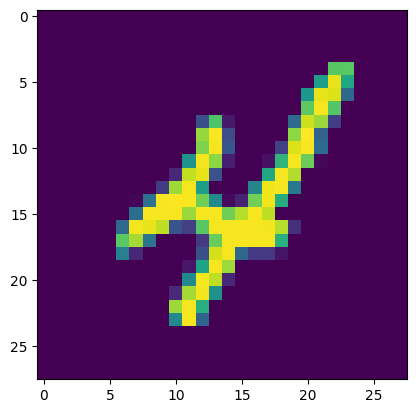

In [5]:
import matplotlib.pyplot as plt

plt.imshow(train_data.data[9])
plt.show()

In [6]:
# Batch 처리를 위한 데이터 로더

from torch.utils.data.dataloader import DataLoader

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "cuda" if torch.cuda.is_available() else "cpu" # 강사님이 알려주신 설정
device

device(type='cpu')

In [9]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        return self.fc3(x)
    
# model = MLP().to(device)
model = MLP()

### MLP(Multi-Layer Perceptron) 구조 완전 분석

#### 🧠 Chain of Thought: 강사님의 설계 의도 파악

##### 1단계: CNN vs MLP의 근본적인 차이

**CNN과 비교하여 생각해봅시다:**

| 특성 | CNN | MLP |
|------|-----|-----|
| **입력 형태** | 2D/3D 유지 `(1, 28, 28)` | 1D 벡터로 변환 `(784,)` |
| **공간 정보** | 보존 (이웃 픽셀 관계 유지) | 손실 (모든 픽셀을 독립적으로 취급) |
| **연산 방식** | 지역적(Convolution) | 전역적(Fully Connected) |
| **파라미터 효율** | 높음 (가중치 공유) | 낮음 (모든 연결이 독립적) |

**핵심 인사이트**: 
- MLP는 **공간 구조를 고려하지 않음** → 입력을 1차원 벡터로 펼쳐야 함
- 모든 픽셀이 모든 뉴런에 연결됨 → **완전 연결(Fully Connected)**

---

##### 2단계: 왜 784 → 128 → 64 → 10 구조인가?

```python
self.fc1 = nn.Linear(784, 128)   # 입력층 → 은닉층1
self.fc2 = nn.Linear(128, 64)    # 은닉층1 → 은닉층2
self.fc3 = nn.Linear(64, 10)     # 은닉층2 → 출력층
```

**설계 철학: 점진적 차원 축소 (Feature Compression)**

```
784 → 128 → 64 → 10
 ↓     ↓     ↓    ↓
원본  압축1 압축2 분류
```

이는 **정보의 계층적 압축(Hierarchical Compression)** 전략입니다.

---

#### 🔍 코드 상세 분석

##### Step 1: 입력 차원이 왜 784인가?

```python
self.fc1 = nn.Linear(784, 128)
```

**계산 근거:**

```
MNIST 이미지 크기: 28 × 28 픽셀
1차원 변환: 28 × 28 = 784

시각화:
[[ 0,  1,  2, ..., 27],     →  [0, 1, 2, ..., 783]
 [28, 29, 30, ..., 55],         (784개의 1차원 벡터)
 ...
 [756, 757, ..., 783]]
```

**왜 1차원으로 변환해야 하나?**

MLP의 `nn.Linear`는 **행렬 곱셈(Matrix Multiplication)**을 수행합니다:

```
입력 벡터 (1 × 784) × 가중치 행렬 (784 × 128) = 출력 (1 × 128)
```

만약 2D 형태 `(28, 28)`을 그대로 입력하면:
- 행렬 곱셈이 정의되지 않음
- Linear 층은 마지막 차원만 변환 가능

**따라서 반드시 평탄화(Flatten)가 필요합니다!**

---

##### Step 2: 왜 128개 뉴런인가?

```python
self.fc1 = nn.Linear(784, 128)  # 784 → 128로 약 1/6 압축
```

**설계 근거 (CoT):**

1. **정보 압축**: 784개 픽셀 중 많은 부분이 배경(0)
   - 실제 중요한 정보는 훨씬 적음
   - 128차원으로 압축해도 충분히 표현 가능

2. **계산 효율**: 784 → 10으로 직접 연결하지 않는 이유
   - 너무 급격한 압축 → 정보 손실
   - 중간 층이 점진적으로 추상화 수행

3. **파라미터 개수**:
```
직접 연결 (784 → 10):
파라미터 = 784 × 10 + 10 = 7,850개

계층적 연결 (784 → 128 → 10):
FC1 = 784 × 128 + 128 = 100,480
FC2 = 128 × 10 + 10 = 1,290
합계 = 101,770개
```

→ **더 많은 파라미터를 사용하지만, 표현력(Representation Power)이 훨씬 높음!**

**128의 선택 기준:**
- 2의 거듭제곱 근처 (64, 128, 256) → GPU 연산 효율적
- 입력(784)과 출력(10)의 중간 스케일
- 너무 크면: 과적합, 느림
- 너무 작으면: 과소적합, 표현력 부족

---

##### Step 3: 왜 128 → 64로 또 압축하는가?

```python
self.fc2 = nn.Linear(128, 64)  # 128 → 64로 1/2 압축
```

**설계 근거 (CoT):**

**계층적 특징 추출(Hierarchical Feature Learning)**

```
Layer 1 (784 → 128):  저수준 특징
  - 엣지, 곡선, 기본 패턴 감지
  - 예: "여기에 수직선이 있다", "여기에 곡선이 있다"

Layer 2 (128 → 64):   중간 수준 특징
  - 저수준 특징들을 조합
  - 예: "수직선 + 곡선 = 숫자 6의 일부"

Layer 3 (64 → 10):    고수준 특징 (분류)
  - 최종 클래스 판단
  - 예: "이것은 숫자 6이다"
```

**왜 한 번에 128 → 10으로 가지 않나?**

```python
# 옵션 1: 직접 연결 (얕은 네트워크)
fc1: 784 → 128
fc2: 128 → 10

# 옵션 2: 계층적 연결 (깊은 네트워크) ← 강사님 선택
fc1: 784 → 128
fc2: 128 → 64
fc3: 64 → 10
```

**깊은 네트워크의 장점:**
1. **더 복잡한 패턴 학습** 가능
2. **점진적 추상화** → 안정적 학습
3. **Gradient Flow** 개선 (ReLU와 함께 사용 시)

---

##### Step 4: ReLU 활성화 함수의 역할

```python
self.relu1 = nn.ReLU()
self.relu2 = nn.ReLU()
```

**왜 각 층마다 ReLU를 넣는가?**

**비선형성(Non-linearity) 추가**

ReLU가 없다면:
```python
# ReLU 없이
x = fc1(x)      # W1 * x + b1
x = fc2(x)      # W2 * (W1 * x + b1) + b2
x = fc3(x)      # W3 * (W2 * (W1 * x + b1) + b2) + b3

# 수학적으로 단순화하면:
x = W_combined * x + b_combined

→ 결국 1개의 선형 층과 동일!
→ 깊게 쌓는 의미가 없음
```

**ReLU가 있으면:**
```python
x = relu(fc1(x))    # max(0, W1 * x + b1)
x = relu(fc2(x))    # max(0, W2 * max(...))
x = fc3(x)

→ 비선형 변환 → 복잡한 패턴 학습 가능
```

**ReLU의 특징:**
- `ReLU(x) = max(0, x)`
- 음수는 0으로, 양수는 그대로
- 계산이 매우 빠름
- Gradient Vanishing 문제 완화

**왜 마지막 fc3 뒤에는 ReLU가 없나?**
```python
self.fc3 = nn.Linear(64, 10)  # ReLU 없음!
```

→ 출력층은 **10개 클래스의 점수(logits)** 를 출력해야 함
→ 음수 값도 필요 (어떤 클래스가 아닐 확률 표현)
→ 이후 `CrossEntropyLoss`가 내부적으로 Softmax 적용

---

#### 🔄 Forward Pass 동작 흐름

##### 전체 데이터 흐름

```python
def forward(self, x):
    x = x.view(x.size(0), -1)        # Step 1: 평탄화
    x = self.relu1(self.fc1(x))      # Step 2: FC1 + ReLU
    x = self.relu2(self.fc2(x))      # Step 3: FC2 + ReLU
    return self.fc3(x)               # Step 4: FC3 (출력)
```

##### Step-by-Step 상세 분석

###### **Step 1: 평탄화 (Flatten)**

```python
x = x.view(x.size(0), -1)
```

**동작 분석:**

```python
# 입력 형태 (예: batch_size=32)
x.shape: (32, 1, 28, 28)
         ↑   ↑   ↑   ↑
       batch ch  H   W

x.size(0) = 32  # 배치 크기
-1 = 자동 계산   # 나머지 차원을 하나로 합침

# 출력 형태
x.shape: (32, 784)
         ↑    ↑
       batch 1×28×28=784
```

**`view(-1)` vs `view(x.size(0), -1)` 비교:**

```python
# 잘못된 방법
x = x.view(-1)  
# 결과: (32×784=25088,) → 배치 구분이 사라짐! ❌

# 올바른 방법
x = x.view(x.size(0), -1)
# 결과: (32, 784) → 배치 유지 ✓
```

**왜 이렇게 해야 하나?**
- `x.size(0)`: 배치 차원을 명시적으로 보존
- `-1`: 나머지 차원은 자동 계산 (1×28×28 → 784)
- 배치 단위 병렬 처리 유지

---

###### **Step 2: 첫 번째 은닉층**

```python
x = self.relu1(self.fc1(x))
```

**단계별 분해:**

```python
# fc1 적용
z1 = self.fc1(x)  # (32, 784) × (784, 128) → (32, 128)
                   # 가중치: 100,352개 (784×128 + 128)

# relu1 적용
x = self.relu1(z1)  # max(0, z1)
```

**내부 동작:**

```
입력: [0.5, -0.3, 0.8, -1.2, ...]  (784개 값)
      ↓ (가중치 행렬 곱셈)
중간: [2.1, -0.5, 1.3, -0.8, ...]  (128개 값)
      ↓ (ReLU 적용)
출력: [2.1,  0.0, 1.3,  0.0, ...]  (128개 값, 음수→0)
```

**의미:**
- 784개 픽셀 정보를 128개 특징으로 압축
- 음수(비활성) 뉴런 제거 → 희소성(Sparsity)
- 다음 층에 중요한 특징만 전달

---

###### **Step 3: 두 번째 은닉층**

```python
x = self.relu2(self.fc2(x))
```

**단계별 분해:**

```python
# fc2 적용
z2 = self.fc2(x)  # (32, 128) × (128, 64) → (32, 64)
                   # 가중치: 8,256개 (128×64 + 64)

# relu2 적용
x = self.relu2(z2)  # max(0, z2)
```

**추상화 수준 증가:**

```
Layer 1 (128개 특징):
  - "여기 수직선", "여기 곡선", "여기 교차점" ...

Layer 2 (64개 특징):
  - "수직선 + 곡선 조합", "특정 형태 패턴" ...
  - 더 고수준의 의미 추출
```

---

###### **Step 4: 출력층**

```python
return self.fc3(x)
```

**최종 변환:**

```python
output = self.fc3(x)  # (32, 64) × (64, 10) → (32, 10)
                       # 가중치: 650개 (64×10 + 10)
```

**출력 형태:**

```python
# 예시 출력 (1개 샘플)
tensor([[-2.3,  0.5,  1.2,  3.5, -0.8,  0.2, -1.5,  2.1, -0.3,  0.9]])
          ↑     ↑     ↑     ↑     ↑     ↑     ↑     ↑     ↑     ↑
         클래스0 1    2     3     4     5     6     7     8     9

# 가장 큰 값: 3.5 (클래스 3)
# 예측: 이 이미지는 숫자 "3"
```

**ReLU를 적용하지 않는 이유:**
- 음수 값도 의미가 있음 (낮은 확률/신뢰도)
- Loss 함수(CrossEntropy)가 logits를 받아 Softmax 처리
- 출력 범위 제한하면 학습 불안정

---

#### 📊 전체 구조 비교표

##### MLP vs CNN 비교

```python
# MLP (이번 코드)
Input (28×28) → Flatten(784) → FC(128) → FC(64) → FC(10)

# CNN (이전 코드)
Input (28×28) → Conv(32) → Conv(64) → Pool → Flatten(10816) → FC(100) → FC(10)
```

| 구조 요소 | MLP | CNN |
|-----------|-----|-----|
| **초기 처리** | 즉시 Flatten | 공간 구조 유지 |
| **특징 추출** | Fully Connected | Convolution |
| **파라미터 수** | 많음 | 적음 (가중치 공유) |
| **공간 정보** | 손실 | 보존 |
| **성능 (이미지)** | 낮음 | 높음 |
| **학습 속도** | 빠름 | 느림 |

---

#### 🔢 파라미터 계산 상세

##### 전체 파라미터 분석

```python
# FC1
가중치: 784 × 128 = 100,352
편향:   128
소계:   100,480개

# FC2
가중치: 128 × 64 = 8,192
편향:   64
소계:   8,256개

# FC3
가중치: 64 × 10 = 640
편향:   10
소계:   650개

━━━━━━━━━━━━━━━━━━━━━━━
총 파라미터: 109,386개
```

**CNN과 비교:**
- CNN: 1,101,526개 (MLP의 약 10배)
- MLP: 109,386개

**왜 이렇게 차이가 나는가?**
```
CNN의 fc1: 10,816 → 100 (1,081,700개 파라미터)
MLP의 fc1: 784 → 128 (100,480개 파라미터)

→ Flatten 후 크기가 CNN이 훨씬 큼 (10,816 vs 784)
→ CNN은 Conv로 채널이 증가했기 때문
```

---

#### 💡 설계 철학 정리

##### 강사님이 이 구조를 선택한 이유

###### **1. 교육적 목적**
```
단순 → 복잡 순서로 학습
MLP (기본) → CNN (심화)
```

###### **2. 점진적 압축 전략**
```
784 → 128 (약 1/6 압축)
128 → 64  (1/2 압축)
64 → 10   (클래스 분류)

급격한 압축보다 점진적 압축이 안정적
```

###### **3. 적절한 은닉층 크기**
- **128**: 충분한 표현력, GPU 효율적
- **64**: 추가 추상화, 과적합 방지
- **2개 은닉층**: 얕지도 깊지도 않은 적정 깊이

###### **4. ReLU 배치**
- 각 은닉층 후: 비선형성 추가
- 출력층 전: 없음 (logits 출력)

---

#### 🎯 핵심 개념 요약

##### ✅ 반드시 기억할 것

###### **1. MLP는 1D 입력만 받음**
```python
x = x.view(x.size(0), -1)  # (B, 1, 28, 28) → (B, 784)
```
→ 공간 구조 무시, 모든 픽셀을 독립적으로 취급

###### **2. 계층적 차원 축소**
```
784 → 128 → 64 → 10
원본    저수준   중간   분류
```
→ 각 층이 더 추상적인 특징 학습

###### **3. ReLU는 비선형성 제공**
```
선형층만: f(f(x)) = f'(x) (여전히 선형)
ReLU 추가: 복잡한 비선형 패턴 학습 가능
```

###### **4. 출력층에는 활성화 함수 없음**
```
FC3 → 직접 출력 (logits)
→ CrossEntropyLoss가 Softmax 처리
```

###### **5. 배치 차원 보존**
```python
x.view(x.size(0), -1)  # 배치 유지 ✓
x.view(-1)             # 배치 손실 ❌
```

---

#### 🚀 실전 활용 팁

##### MLP를 개선하려면?

###### **1. 더 깊게 만들기**
```python
fc1: 784 → 256
fc2: 256 → 128
fc3: 128 → 64
fc4: 64 → 10
```

###### **2. Dropout 추가 (과적합 방지)**
```python
self.dropout = nn.Dropout(0.5)

def forward(self, x):
    x = self.dropout(self.relu1(self.fc1(x)))
    x = self.dropout(self.relu2(self.fc2(x)))
    return self.fc3(x)
```

###### **3. Batch Normalization**
```python
self.bn1 = nn.BatchNorm1d(128)
self.bn2 = nn.BatchNorm1d(64)
```

###### **4. 다른 활성화 함수**
```python
self.relu1 = nn.LeakyReLU()  # 음수도 약간 통과
self.relu2 = nn.ELU()        # 음수에서 부드러운 곡선
```

하지만 **이미지에는 CNN이 훨씬 효과적**이라는 것을 기억하세요!

In [10]:
model

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [11]:
model.to(device)

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [12]:
# 학습
from torch.optim.adam import Adam

learning_rate = 1e-3
optim = Adam(model.parameters(), lr=learning_rate)

for epoch in range(20):
    for data, label in train_loader:
        optim.zero_grad()
        data = torch.reshape(data, (-1, 784)).to(device)
        preds = model(data)

        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optim.step()

    print(f"Epoch {epoch+1} | loss: {loss.item():.4f}")

Epoch 1 | loss: 0.0693
Epoch 2 | loss: 0.1046
Epoch 3 | loss: 0.1928
Epoch 4 | loss: 0.0117
Epoch 5 | loss: 0.0163
Epoch 6 | loss: 0.0745
Epoch 7 | loss: 0.0281
Epoch 8 | loss: 0.0255
Epoch 9 | loss: 0.0077
Epoch 10 | loss: 0.0101
Epoch 11 | loss: 0.0043
Epoch 12 | loss: 0.0054
Epoch 13 | loss: 0.0017
Epoch 14 | loss: 0.0313
Epoch 15 | loss: 0.0015
Epoch 16 | loss: 0.0008
Epoch 17 | loss: 0.0309
Epoch 18 | loss: 0.0013
Epoch 19 | loss: 0.1209
Epoch 20 | loss: 0.0000


### PyTorch 학습 루프 완전 분석: Optimizer와 학습 과정

#### 🧠 Chain of Thought: 학습의 본질 이해하기

##### 근본적인 질문: 딥러닝 학습이란 무엇인가?

```
초기 상태: 랜덤 가중치 → 엉터리 예측
       ↓
    학습 과정 (반복)
       ↓
최종 상태: 최적화된 가중치 → 정확한 예측
```

**핵심**: 
- **학습 = 가중치(Weight) 업데이트 과정**
- **목표**: Loss(손실)를 최소화하는 가중치 찾기
- **방법**: Optimizer(최적화 알고리즘) 사용

---

#### 📚 Optimizer(옵티마이저)란?

##### 개념 정의

```python
from torch.optim.adam import Adam
```

**Optimizer(최적화기)**: 
- 모델의 가중치를 **어떻게(How)** 업데이트할지 결정하는 알고리즘
- Loss를 최소화하는 방향으로 파라미터를 조정
- 경사하강법(Gradient Descent)의 발전된 형태

##### 왜 'optim'이라는 이름을 쓰는가?

```python
optim = Adam(model.parameters(), lr=learning_rate)
#  ↑
# optimization의 줄임말
# 관례적으로 optimizer 객체를 'optim'이라는 변수명으로 저장
```

**비유**:
- 모델 = 자동차
- Loss = 목적지까지의 거리
- Optimizer = 내비게이션 (어느 방향으로 갈지 안내)
- Learning Rate = 자동차 속도

---

#### 🚀 Adam Optimizer란?

##### Adam = **Ada**ptive **M**oment Estimation

```python
from torch.optim.adam import Adam
optim = Adam(model.parameters(), lr=learning_rate)
```

##### Adam의 위치: Optimizer 계보도

```
Gradient Descent (1847)
    ↓
SGD (Stochastic Gradient Descent)
    ↓
    ├─ Momentum (관성 추가)
    ├─ RMSprop (학습률 조정)
    └─ Adam (2014) ← 가장 많이 사용 ⭐
         ↓
    AdamW (가중치 감쇠 개선)
```

##### Adam이 특별한 이유

###### **1. 적응형 학습률 (Adaptive Learning Rate)**

```
일반 SGD: 모든 파라미터에 동일한 학습률
   W1 += -0.001 × gradient1
   W2 += -0.001 × gradient2
   W3 += -0.001 × gradient3

Adam: 각 파라미터마다 다른 학습률
   W1 += -0.003 × gradient1  (빠르게 변화)
   W2 += -0.0001 × gradient2  (천천히 변화)
   W3 += -0.002 × gradient3
```

###### **2. 모멘텀(Momentum) 효과**

```
SGD: 현재 기울기만 사용
   ↓
  ↙ ↓ ↘
 현재 방향으로만 이동 (불안정)

Adam: 과거 기울기 정보도 활용
   ↓
  ↓↓↓
 관성을 가지고 안정적으로 이동
```

###### **3. 자동 조정**

- 기울기가 큰 곳: 학습률 자동 감소 (과도한 변화 방지)
- 기울기가 작은 곳: 학습률 자동 증가 (학습 가속)

##### 왜 강사님이 Adam을 선택했는가?

| 이유 | 설명 |
|------|------|
| **범용성** | 대부분의 문제에서 잘 작동 |
| **안정성** | 학습률 튜닝이 덜 민감 |
| **빠른 수렴** | 적응형 학습률로 효율적 |
| **기본 선택** | 딥러닝 커뮤니티 표준 |
| **초보자 친화적** | 하이퍼파라미터 조정 부담 적음 |

---

#### 🔢 Learning Rate: 왜 1e-3인가?

##### 1e-3의 의미

```python
learning_rate = 1e-3
# 1e-3 = 1 × 10^(-3) = 0.001
```

##### CoT: Learning Rate가 너무 크면 안 되는 이유

###### **시나리오 1: Learning Rate가 너무 클 때 (예: 1.0)**

```
현재 Loss: 2.5
최적 가중치: 3.0
현재 가중치: 2.0

업데이트:
W_new = W_old - lr × gradient
W_new = 2.0 - 1.0 × 1.0 = 1.0  (너무 많이 이동!)

다음 반복:
W_new = 1.0 - 1.0 × (-2.0) = 3.0  (최적값 통과)

다음 반복:
W_new = 3.0 - 1.0 × 2.0 = 1.0  (다시 멀어짐)

결과: 진동하며 수렴 실패! ❌
```

**시각화:**
```
Loss
 │
 │    *           *
 │       *     *
 │         * *
 │─────────────────── Weight
      진동하며 발산
```

###### **시나리오 2: Learning Rate가 적절할 때 (예: 0.001)**

```
현재 가중치: 2.0
최적 가중치: 3.0

업데이트:
W = 2.0 - 0.001 × 1.0 = 1.999  (조금 이동)
W = 1.999 - 0.001 × 0.99 = 1.99901
...
점진적으로 3.0에 수렴 ✓
```

**시각화:**
```
Loss
 │ \
 │  \___
 │      \___
 │          \______
 │─────────────────── Weight
    부드럽게 수렴
```

###### **시나리오 3: Learning Rate가 너무 작을 때 (예: 1e-7)**

```
W = 2.0 - 0.0000001 × 1.0 = 1.9999999
W = 1.9999999 - 0.0000001 × 1.0 = 1.9999998
...

문제: 
- 100만 번 반복해도 거의 변화 없음
- 학습 시간이 너무 오래 걸림
- 실용적이지 않음
```

##### Learning Rate 비교표

| Learning Rate | 효과 | 문제점 |
|--------------|------|--------|
| **1.0** | 매우 큰 변화 | 발산, 진동 |
| **0.1** | 큰 변화 | 불안정, 최적값 통과 |
| **0.01** | 적당한 변화 | 약간 불안정 |
| **0.001 (1e-3)** ⭐ | 안정적 수렴 | 균형 잡힘 |
| **0.0001 (1e-4)** | 매우 안정적 | 느린 학습 |
| **0.00001 (1e-5)** | 거의 변화 없음 | 너무 느림 |

##### 왜 1e-3이 표준인가?

**경험적 발견 (Empirical Finding):**

```python
# 딥러닝 커뮤니티의 경험적 권장값
SGD:      lr = 0.01 ~ 0.1
Adam:     lr = 0.001 (1e-3)  ← 가장 보편적 ⭐
AdamW:    lr = 0.0001 ~ 0.001
RMSprop:  lr = 0.001
```

**1e-3이 좋은 이유:**
1. **안정적 수렴**: 너무 빠르지도, 느리지도 않음
2. **Adam과 궁합**: Adam의 적응형 학습률과 조화
3. **범용성**: 대부분의 문제에서 좋은 출발점
4. **검증됨**: 수많은 논문과 실험에서 입증

---

#### 📝 코드 라인별 상세 분석

##### Line 1-2: Optimizer Import

```python
from torch.optim.adam import Adam
```

**의미:**
- `torch.optim`: PyTorch의 최적화 모듈
- `.adam`: Adam optimizer 서브모듈
- `Adam`: Adam 클래스 import

**대안:**
```python
# 방법 1 (강사님 방식)
from torch.optim.adam import Adam

# 방법 2 (더 일반적)
import torch.optim as optim
optimizer = optim.Adam(...)

# 방법 3
from torch import optim
optimizer = optim.Adam(...)
```

---

##### Line 4-5: Optimizer 생성

```python
learning_rate = 1e-3
optim = Adam(model.parameters(), lr=learning_rate)
```

###### **`model.parameters()`의 의미**

```python
# model.parameters()는 Generator 객체
# 모델의 모든 학습 가능한 파라미터를 반환

for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

# 출력:
# fc1.weight: torch.Size([128, 784])
# fc1.bias: torch.Size([128])
# fc2.weight: torch.Size([64, 128])
# fc2.bias: torch.Size([64])
# fc3.weight: torch.Size([10, 64])
# fc3.bias: torch.Size([10])
```

**왜 `model.parameters()`를 전달하는가?**

→ Optimizer가 **어떤 가중치를 업데이트할지** 알아야 하기 때문

```python
optim = Adam(model.parameters(), lr=learning_rate)
              ↑
         optimizer가 관리할 파라미터 목록
```

###### **`lr=learning_rate`의 의미**

```python
lr=learning_rate  # lr = learning rate
lr=1e-3          # 0.001의 과학적 표기법
```

**Adam의 다른 파라미터 (선택사항):**

```python
optim = Adam(
    model.parameters(),
    lr=1e-3,              # 학습률
    betas=(0.9, 0.999),   # 모멘텀 계수 (기본값)
    eps=1e-8,             # 수치 안정성 (기본값)
    weight_decay=0        # L2 정규화 (기본값)
)
```

강사님은 기본값이 이미 좋기 때문에 `lr`만 명시!

---

##### Line 7-17: 학습 루프 (Training Loop)

```python
for epoch in range(20):
    for data, label in train_loader:
        optim.zero_grad()
        data = torch.reshape(data, (-1, 784)).to(device)
        preds = model(data)
        
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optim.step()
    
    print(f"Epoch {epoch+1} | loss: {loss.item():.4f}")
```

##### Step-by-Step 분석

###### **Line 7: Epoch 반복**

```python
for epoch in range(20):
```

**Epoch란?**
- **1 Epoch** = 전체 훈련 데이터를 한 번 모두 본 것
- 20 Epochs = 전체 데이터를 20번 반복 학습

**왜 여러 번 반복하는가?**

```
1 Epoch:  데이터 → 학습 → 조금 개선
2 Epoch:  같은 데이터 → 학습 → 더 개선
3 Epoch:  같은 데이터 → 학습 → 더 개선
...
20 Epoch: 충분히 학습됨
```

**시각화:**
```
Loss
 │ \
 │  \___      Epoch 1-5: 빠른 감소
 │      \___  Epoch 6-15: 점진적 감소
 │          \____ Epoch 16-20: 수렴
 │─────────────────── Epoch
```

---

###### **Line 8: Batch 반복**

```python
for data, label in train_loader:
```

**Batch란?**
- 전체 데이터를 작은 묶음으로 나눈 것
- 예: 60,000개 데이터 → 32개씩 묶음 → 1,875 batches

**`train_loader`의 역할:**

```python
# train_loader 예시 (batch_size=32)
# Batch 1: data.shape = (32, 1, 28, 28), label.shape = (32,)
# Batch 2: data.shape = (32, 1, 28, 28), label.shape = (32,)
# ...
# Batch 1875: data.shape = (32, 1, 28, 28), label.shape = (32,)
```

**왜 Batch로 나누는가?**

| 방식 | 장점 | 단점 |
|------|------|------|
| **전체 데이터 한번에** | 정확한 기울기 | 메모리 부족, 느림 |
| **1개씩** | 빠름, 메모리 효율 | 불안정, 노이즈 많음 |
| **Batch (32~128개)** ⭐ | 균형 잡힘 | 최적의 선택 |

---

###### **Line 9: Gradient 초기화**

```python
optim.zero_grad()
```

**왜 필요한가?**

**PyTorch의 특징: Gradient 자동 누적**

```python
# 첫 번째 batch
loss1.backward()  # gradient 계산 → 저장

# 두 번째 batch (zero_grad() 없으면)
loss2.backward()  # gradient 계산 → 이전 gradient에 더해짐! ❌

# 결과: gradient = grad1 + grad2 (잘못된 값)
```

**올바른 방법:**

```python
# Batch 1
optim.zero_grad()    # gradient 초기화
loss1.backward()     # gradient 계산
optim.step()         # 업데이트

# Batch 2
optim.zero_grad()    # gradient 다시 초기화 ✓
loss2.backward()     # 새로운 gradient 계산
optim.step()         # 업데이트
```

**내부 동작:**

```python
# optim.zero_grad() 실행 전
fc1.weight.grad = tensor([[0.5, -0.3, ...]])  # 이전 값

# optim.zero_grad() 실행 후
fc1.weight.grad = tensor([[0.0, 0.0, ...]])   # 초기화됨
```

---

###### **Line 10: 데이터 변환 및 GPU 전송**

```python
data = torch.reshape(data, (-1, 784)).to(device)
```

**두 가지 작업을 동시에:**

####### **1. `torch.reshape(data, (-1, 784))`**

```python
# 입력 형태
data.shape: (32, 1, 28, 28)
             ↑   ↑   ↑   ↑
          batch ch  H   W

# 출력 형태
reshaped.shape: (32, 784)
                 ↑    ↑
              batch  flattened
```

**`-1`의 의미:**
```python
-1 = 자동 계산
32 × 1 × 28 × 28 = 25,088개 원소
25,088 / 784 = 32

따라서 (-1, 784) = (32, 784)
```

**왜 reshape가 필요한가?**
→ MLP는 1D 입력만 받기 때문 (이전 설명 참조)

####### **2. `.to(device)`**

```python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# GPU 사용 가능하면
data.to(device)  # → GPU로 이동

# GPU 없으면
data.to(device)  # → CPU에 그대로
```

**왜 필요한가?**
- 모델이 GPU에 있으면 데이터도 GPU에 있어야 함
- CPU 데이터 × GPU 모델 = 오류! ❌
- 동일한 장치에 있어야 연산 가능

---

###### **Line 11: Forward Pass (예측)**

```python
preds = model(data)
```

**실제 동작:**

```python
# model(data)는 model.forward(data)를 호출
preds = model.forward(data)

# MLP 내부에서:
# x = x.view(x.size(0), -1)  # 이미 reshape 됨
# x = relu(fc1(x))
# x = relu(fc2(x))
# x = fc3(x)
# return x
```

**출력 형태:**

```python
data.shape:   (32, 784)    # 입력
preds.shape:  (32, 10)     # 출력

# 예시 출력 (1개 샘플)
preds[0] = tensor([-2.3, 0.5, 1.2, 3.5, -0.8, 0.2, -1.5, 2.1, -0.3, 0.9])
                    ↑    ↑    ↑    ↑     ↑    ↑     ↑    ↑     ↑    ↑
                   class 0~9에 대한 점수 (logits)
```

---

###### **Line 13: Loss 계산**

```python
loss = nn.CrossEntropyLoss()(preds, label.to(device))
```

**분해해서 이해하기:**

```python
# 방법 1 (강사님 방식 - 한 줄)
loss = nn.CrossEntropyLoss()(preds, label.to(device))

# 방법 2 (분해)
criterion = nn.CrossEntropyLoss()        # Loss 함수 생성
loss = criterion(preds, label.to(device)) # Loss 계산
```

**CrossEntropyLoss의 역할:**

```python
# 예시
preds[0] = [-2.3, 0.5, 1.2, 3.5, ...]  # 모델 예측
label[0] = 3                            # 정답 클래스

# 내부 동작:
# 1. Softmax로 확률 변환
probs = softmax(preds[0]) 
# → [0.001, 0.020, 0.038, 0.900, ...]

# 2. 정답 클래스의 확률 추출
target_prob = probs[3] = 0.900

# 3. Loss 계산 (음의 로그 확률)
loss = -log(0.900) = 0.105

# 확률이 높을수록 (정확할수록) loss가 낮음!
```

**Loss 값의 의미:**

| Loss | 의미 | 상태 |
|------|------|------|
| **0.0** | 완벽한 예측 | 이상적 (실제로는 불가능) |
| **0.1 ~ 0.5** | 매우 좋은 예측 | 잘 학습됨 |
| **1.0 ~ 2.0** | 괜찮은 예측 | 학습 중 |
| **2.3** | 랜덤 수준 (10개 클래스) | 초기 상태 |
| **10+** | 매우 나쁜 예측 | 문제 있음 |

**`label.to(device)`의 이유:**
```python
preds: GPU에 있음
label: CPU에 있음
→ 오류 발생!

label.to(device)로 GPU로 이동 필요
```

---

###### **Line 14: Backward Pass (기울기 계산)**

```python
loss.backward()
```

**마법의 한 줄: 자동 미분 (Autograd)**

```python
# 이 한 줄이 하는 일:
# 1. Loss에서 모든 파라미터까지 역전파
# 2. 각 파라미터의 gradient 계산
# 3. param.grad에 저장
```

**내부 동작 시각화:**

```
Forward Pass:
Input → FC1 → ReLU → FC2 → ReLU → FC3 → Loss
                                          ↓

Backward Pass (loss.backward()):
←───────←──────←──────←──────←──────← Loss
gradient 계산하며 역방향 전파
```

**결과:**

```python
# backward() 실행 전
model.fc1.weight.grad  # None

# backward() 실행 후
model.fc1.weight.grad  # tensor([[0.001, -0.002, ...]])
model.fc1.bias.grad    # tensor([0.003, ...])
model.fc2.weight.grad  # tensor([[...]])
# ... 모든 파라미터의 gradient 계산됨
```

**Gradient의 의미:**
```
gradient > 0: 가중치 증가 시 Loss 증가 → 가중치 감소 필요
gradient < 0: 가중치 증가 시 Loss 감소 → 가중치 증가 필요
gradient = 0: 최적점 (이론적)
```

---

###### **Line 15: 가중치 업데이트**

```python
optim.step()
```

**실제 학습이 일어나는 순간!**

```python
# optim.step()이 하는 일:

for param in model.parameters():
    # Adam 알고리즘 적용
    # param = param - lr × gradient (단순화)
    
    # 실제는 더 복잡:
    # - 모멘텀 계산
    # - 적응형 학습률 계산
    # - 가중치 업데이트
    param.data = param.data - lr × adjusted_gradient
```

**예시 (단순화):**

```python
# 업데이트 전
fc1.weight[0][0] = 0.532

# gradient
fc1.weight.grad[0][0] = 0.012

# 업데이트 (lr=0.001)
fc1.weight[0][0] = 0.532 - 0.001 × 0.012
                 = 0.532 - 0.000012
                 = 0.531988  ✓
```

**중요:** 
- `optim.step()` 없으면 학습 안 됨!
- Gradient만 계산하고 업데이트하지 않는 것

---

###### **Line 17: Loss 출력**

```python
print(f"Epoch {epoch+1} | loss: {loss.item():.4f}")
```

**각 요소 분석:**

```python
f"Epoch {epoch+1} | loss: {loss.item():.4f}"
#   ↑      ↑               ↑        ↑
#   f-string epoch 번호    tensor→float  소수점 4자리
```

####### **`epoch+1`의 이유:**

```python
range(20)  # 0, 1, 2, ..., 19
epoch+1    # 1, 2, 3, ..., 20 (사람이 읽기 편함)
```

####### **`loss.item()`의 의미:**

```python
loss         # tensor(0.5234, grad_fn=<NllLossBackward>)
loss.item()  # 0.5234 (Python float)

# 왜 필요한가?
print(loss)       # tensor(0.5234, grad_fn=...) - 복잡함
print(loss.item()) # 0.5234 - 깔끔함
```

####### **`.4f`의 의미:**

```python
:.4f  # 소수점 4자리까지 표시

loss.item() = 0.52341287
f"{loss.item():.4f}"  # "0.5234"
f"{loss.item():.2f}"  # "0.52"
```

**출력 예시:**

```
Epoch 1 | loss: 2.3045
Epoch 2 | loss: 0.8912
Epoch 3 | loss: 0.4523
...
Epoch 20 | loss: 0.1234
```

---

#### 🔄 전체 학습 과정 흐름도

##### 한 Epoch의 전체 흐름

```python
for epoch in range(20):                              # Epoch 반복
    for data, label in train_loader:                 # Batch 반복 (1875회)
        # ────────────────────────────────────────
        # 1. 초기화
        optim.zero_grad()                            # Gradient 초기화
        
        # 2. Forward Pass
        data = torch.reshape(data, (-1, 784)).to(device)  # 전처리
        preds = model(data)                          # 예측
        
        # 3. Loss 계산
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        
        # 4. Backward Pass
        loss.backward()                              # Gradient 계산
        
        # 5. 업데이트
        optim.step()                                 # 가중치 업데이트
        # ────────────────────────────────────────
    
    print(f"Epoch {epoch+1} | loss: {loss.item():.4f}")
```

##### 시간 순서대로 상세 분석

```
Epoch 1 시작
│
├─ Batch 1 (32개 이미지)
│  ├─ zero_grad():     gradient = 0으로 초기화
│  ├─ forward():       예측값 계산
│  ├─ loss 계산:       예측과 정답 비교 → 2.3045
│  ├─ backward():      gradient 계산
│  └─ step():          가중치 업데이트
│
├─ Batch 2 (32개 이미지)
│  ├─ zero_grad():     gradient = 0으로 초기화
│  ├─ forward():       예측값 계산
│  ├─ loss 계산:       예측과 정답 비교 → 2.2891
│  ├─ backward():      gradient 계산
│  └─ step():          가중치 업데이트
│
├─ ...
│
└─ Batch 1875 (마지막)
   └─ loss: 0.5234

Epoch 1 완료 → "Epoch 1 | loss: 0.5234" 출력

Epoch 2 시작
│
└─ ... (반복)
```

---

#### 💡 핵심 개념 정리

##### ✅ 5단계 학습 사이클

```
1. zero_grad()    → 과거 gradient 지우기
2. forward()      → 예측하기
3. loss 계산      → 얼마나 틀렸는지 측정
4. backward()     → 어떻게 고칠지 계산 (gradient)
5. step()         → 실제로 고치기 (가중치 업데이트)

→ 이 과정을 수천~수만 번 반복!
```

##### ✅ 용어 정리

| 용어 | 의미 | 비유 |
|------|------|------|
| **Optimizer** | 학습 알고리즘 | 내비게이션 |
| **Learning Rate** | 학습 속도 | 자동차 속도 |
| **Gradient** | 개선 방향 | 내비게이션 화살표 |
| **Loss** | 오차 | 목적지까지 거리 |
| **Epoch** | 전체 데이터 1회 | 교재 1회독 |
| **Batch** | 데이터 묶음 | 교재 1챕터 |

##### ✅ 왜 이런 순서인가?

```python
# 잘못된 순서 ❌
optim.step()       # 뭘 업데이트? gradient 없음!
loss.backward()    # gradient 계산
optim.zero_grad()  # 방금 계산한 gradient 지움!

# 올바른 순서 ✓
optim.zero_grad()  # 1. 과거 정리
# forward & loss   # 2. 예측 & 평가
loss.backward()    # 3. 개선 방향 계산
optim.step()       # 4. 실제 개선
```

---

#### 🎯 자주 하는 실수와 해결

##### 실수 1: zero_grad() 빠뜨림

```python
# 잘못된 코드 ❌
for data, label in train_loader:
    # optim.zero_grad()  ← 빠뜨림!
    preds = model(data)
    loss.backward()
    optim.step()

# 결과: gradient가 누적됨 → 잘못된 학습
```

##### 실수 2: device 불일치

```python
# 잘못된 코드 ❌
model.to('cuda')
data = data  # CPU에 그대로
preds = model(data)  # 오류!

# 올바른 코드 ✓
model.to(device)
data = data.to(device)
preds = model(data)
```

### 실수 3: step() 빠뜨림

```python
# 잘못된 코드 ❌
optim.zero_grad()
loss.backward()
# optim.step()  ← 빠뜨림!

# 결과: gradient만 계산, 업데이트 안 됨 → 학습 안 됨
```

---

#### 🚀 실전 팁

##### Adam의 대안들

```python
# SGD (간단하지만 느림)
optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Adam (범용적, 추천) ⭐
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

# AdamW (최신, 성능 개선)
optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)

# RMSprop (RNN에 좋음)
optim = torch.optim.RMSprop(model.parameters(), lr=1e-3)
```

##### Learning Rate 스케줄링

```python
# 학습 중간에 learning rate 감소
from torch.optim.lr_scheduler import StepLR

optim = Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optim, step_size=10, gamma=0.1)

for epoch in range(20):
    # 학습...
    scheduler.step()  # 10 epoch마다 lr × 0.1
```

##### 학습 모니터링 개선

```python
# 더 상세한 출력
for epoch in range(20):
    total_loss = 0
    for data, label in train_loader:
        # ... 학습 코드 ...
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")
```

이제 강사님의 학습 코드를 완벽하게 이해하셨습니다! 🎉

In [ ]:
# 모델 가중치 저장, model.state_dict() 형태로 저장 → 모델의 가중치만 저장
torch.save(model.state_dict(), "MNIST.pt") # pt, pth, pkl, json, ...

In [ ]:
# 모델 로드 -> 우리는 모델을 저장한 것은 아니므로, 모델을 생성해야 함
model.load_state_dict(torch.load("MNIST.pt", map_location=device)) # map_location=device → 모델을 저장한 장치와 동일한 장치에 로드

<All keys matched successfully>

In [17]:
# 모델 에측 및 평가
correct = 0

with torch.no_grad():
    for data, label in test_loader:
        data = torch.reshape(data, (-1, 784)).to(device)

        output = model(data)
        preds = output.data.max(1)[1]

        corr = preds.eq(label.to(device).data).sum().item()
        correct += corr
    
    print(f"Accuracy: {correct / len(test_data)}")

Accuracy: 0.9791


### 모델 평가(Evaluation) 코드 완전 분석

#### 🧠 Chain of Thought: 평가 vs 학습의 차이

##### 근본적인 질문: 왜 평가 코드가 학습 코드와 다른가?

```
학습(Training):
- 목적: 가중치 업데이트
- Gradient 필요: ✓ (backward 필요)
- 데이터: train_loader
- 모드: 학습 모드

평가(Evaluation):
- 목적: 성능 측정
- Gradient 필요: ✗ (backward 불필요)
- 데이터: test_loader
- 모드: 평가 모드
```

**핵심 차이점:**
- 평가할 때는 **가중치를 업데이트하지 않음**
- 따라서 **gradient 계산이 불필요** → 메모리 절약, 속도 향상
- **새로운 데이터(test set)**로 성능 측정

---

#### 📝 코드 전체 구조 이해

##### 학습 vs 평가 코드 비교

```python
# ========== 학습 코드 ==========
for epoch in range(20):
    for data, label in train_loader:    # 학습 데이터
        optim.zero_grad()               # Gradient 초기화 ✓
        preds = model(data)             # 예측
        loss = criterion(preds, label)  # Loss 계산 ✓
        loss.backward()                 # Gradient 계산 ✓
        optim.step()                    # 가중치 업데이트 ✓

# ========== 평가 코드 ==========
correct = 0
with torch.no_grad():                   # Gradient 계산 비활성화 ✓
    for data, label in test_loader:     # 테스트 데이터
        output = model(data)            # 예측
        # loss 계산 없음                # Loss 불필요 ✗
        # backward 없음                 # Gradient 계산 불필요 ✗
        # step 없음                     # 가중치 업데이트 불필요 ✗
        
        # 정확도 계산만 수행
        preds = output.data.max(1)[1]
        correct += preds.eq(label).sum().item()
```

---

#### 🔍 코드 라인별 상세 분석

##### Line 2: correct 변수 초기화

```python
correct = 0
```

###### **왜 0으로 초기화하는가?**

**CoT (사고 과정):**

```
테스트 데이터: 10,000개 이미지
목표: 몇 개를 맞췄는지 세기

방법:
1. correct = 0으로 시작
2. 각 배치마다 맞춘 개수 더하기
3. 최종: 전체 맞춘 개수 / 전체 개수 = 정확도
```

**동작 예시:**

```python
correct = 0  # 초기값

# Batch 1: 32개 중 28개 맞춤
correct += 28  # correct = 28

# Batch 2: 32개 중 30개 맞춤
correct += 30  # correct = 58

# Batch 3: 32개 중 29개 맞춤
correct += 29  # correct = 87

# ...
# 모든 배치 완료
# correct = 9,523

# 정확도 계산
accuracy = 9523 / 10000 = 0.9523 = 95.23%
```

**역할:**
- **누적 카운터(Accumulator)** 역할
- 전체 테스트 데이터에서 맞춘 개수를 누적
- 초기화하지 않으면 이전 값이 남아있음 → 잘못된 계산

---

##### Line 4: with torch.no_grad()

```python
with torch.no_grad():
```

###### **`with` 문이란?**

**Python의 Context Manager (컨텍스트 관리자)**

```python
# with 문의 기본 구조
with [expression] as [variable]:
    # 코드 블록
    pass

# with 문이 하는 일:
# 1. 진입 시: __enter__() 호출 (설정)
# 2. 블록 실행
# 3. 종료 시: __exit__() 호출 (정리)
```

**일상적인 예시:**

```python
# 파일 처리 (가장 흔한 예)
with open('file.txt', 'r') as f:
    content = f.read()
    # 자동으로 파일 닫힘 (f.close() 불필요)

# with 없이 작성하면:
f = open('file.txt', 'r')
try:
    content = f.read()
finally:
    f.close()  # 수동으로 닫아야 함
```

**장점:**
- 자동으로 **설정(setup)과 정리(cleanup)** 처리
- 코드가 간결해짐
- 에러 발생해도 안전하게 정리됨

---

###### **`torch.no_grad()`란?**

**Gradient 계산을 비활성화하는 Context Manager**

```python
with torch.no_grad():
    # 이 블록 안에서는 gradient 계산 안 함
    output = model(data)
    # gradient 추적 비활성화 상태
```

###### **왜 필요한가? (CoT)**

**시나리오 1: 평가 시 no_grad() 사용 안 하면**

```python
# torch.no_grad() 없이
for data, label in test_loader:
    output = model(data)  
    # PyTorch는 자동으로:
    # 1. 모든 연산 기록 (computation graph 생성)
    # 2. Gradient 계산 준비
    # 3. 중간 값들 메모리에 저장
    
    # 문제:
    # - backward()를 호출하지 않을 건데 불필요한 작업
    # - 메모리 낭비
    # - 속도 느림
```

**메모리 사용량 비교:**

```python
# no_grad() 없이
import torch
x = torch.randn(1000, 1000)
model = LargeModel()
output = model(x)
# 메모리 사용: ~500MB (gradient 정보 저장)

# no_grad() 사용
with torch.no_grad():
    output = model(x)
# 메모리 사용: ~100MB (gradient 정보 저장 안 함)

# 약 5배 메모리 절약!
```

**시나리오 2: no_grad() 사용**

```python
with torch.no_grad():
    output = model(data)
    # PyTorch는:
    # 1. 연산만 수행
    # 2. Gradient 계산 준비 안 함
    # 3. 중간 값 저장 안 함
    
    # 장점:
    # ✓ 메모리 절약
    # ✓ 속도 향상
    # ✓ 명확한 의도 표현
```

---

###### **내부 동작 원리**

```python
# 정상적인 forward pass (학습 시)
x = torch.tensor([1.0], requires_grad=True)
y = x * 2
z = y + 3
print(z.requires_grad)  # True (gradient 추적 중)

# no_grad() 사용 (평가 시)
with torch.no_grad():
    x = torch.tensor([1.0], requires_grad=True)
    y = x * 2
    z = y + 3
    print(z.requires_grad)  # False (gradient 추적 안 함)
```

**시각화:**

```
학습 시 (Gradient 추적):
Input → Conv1 → ReLU → ... → Output
  ↓       ↓       ↓            ↓
[저장]  [저장]  [저장]      [저장]
모든 중간 값 메모리에 보관 (backward를 위해)

평가 시 (no_grad):
Input → Conv1 → ReLU → ... → Output
  ↓       ↓       ↓            ↓
[무시]  [무시]  [무시]      [무시]
중간 값 저장 안 함 → 메모리 절약
```

---

###### **with와 torch.no_grad()의 결합**

```python
with torch.no_grad():
    # 진입 시: gradient 추적 비활성화
    for data, label in test_loader:
        output = model(data)
        # 모든 연산이 gradient 추적 없이 수행
    # 종료 시: 원래 상태로 복구

# with 블록 밖에서는 다시 gradient 추적됨
```

**대안 (권장하지 않음):**

```python
# torch.no_grad() 데코레이터 방식
@torch.no_grad()
def evaluate(model, test_loader):
    # 함수 전체에서 gradient 비활성화
    pass

# 수동 설정 (번거로움)
torch.set_grad_enabled(False)
# 평가 코드
torch.set_grad_enabled(True)
```

---

##### Line 5-6: 데이터 로드 및 전처리

```python
for data, label in test_loader:
    data = torch.reshape(data, (-1, 784)).to(device)
```

###### **왜 또 reshape을 해야 하는가?**

**CoT (사고 과정):**

```
질문: 학습할 때도 reshape 했는데 왜 또 해야 하나?

답변: test_loader도 원본 데이터를 반환하기 때문
```

**test_loader의 데이터 형태:**

```python
# test_loader에서 가져온 데이터
data.shape: (32, 1, 28, 28)
            ↑   ↑   ↑   ↑
         batch ch  H   W

# MLP 모델이 원하는 형태
required: (32, 784)
          ↑    ↑
       batch flattened
```

**왜 DataLoader가 자동으로 reshape 안 해주나?**

```python
# DataLoader는 원본 데이터만 제공
test_loader = DataLoader(test_dataset, batch_size=32)

# 장점:
# 1. 범용성: CNN과 MLP 모두 사용 가능
#    - CNN: (B, 1, 28, 28) 그대로 사용
#    - MLP: (B, 1, 28, 28) → (B, 784)로 변환
# 2. 유연성: 모델에 따라 전처리 다르게 가능
```

**학습 vs 평가 코드 비교:**

```python
# 학습 코드
for data, label in train_loader:
    data = torch.reshape(data, (-1, 784)).to(device)  # reshape 필요
    # ...

# 평가 코드
for data, label in test_loader:
    data = torch.reshape(data, (-1, 784)).to(device)  # 똑같이 reshape 필요
    # ...

# 이유: train_loader와 test_loader 모두 동일한 원본 형태 제공
```

---

##### Line 8: Forward Pass (예측)

```python
output = model(data)
```

**학습 시와 동일한 과정:**

```python
# 입력
data.shape: (32, 784)

# MLP forward 내부
x = x.view(x.size(0), -1)  # 이미 (32, 784)라서 변화 없음
x = relu(fc1(x))           # (32, 784) → (32, 128)
x = relu(fc2(x))           # (32, 128) → (32, 64)
x = fc3(x)                 # (32, 64) → (32, 10)

# 출력
output.shape: (32, 10)
```

**output의 내용 (예시):**

```python
output[0] = tensor([-2.3, 0.5, 1.2, 3.5, -0.8, 0.2, -1.5, 2.1, -0.3, 0.9])
                    ↑    ↑    ↑    ↑     ↑    ↑     ↑    ↑     ↑    ↑
                   class 0~9에 대한 점수 (logits)

# 가장 큰 값: 3.5 (index 3)
# 예측: 이 이미지는 숫자 "3"
```

---

##### Line 9: 예측 클래스 추출

```python
preds = output.data.max(1)[1]
```

###### **단계별 분해 분석**

이 한 줄은 **3가지 연산**이 결합된 복잡한 코드입니다!

####### **Step 1: `output.data`**

```python
output.data
```

**의미:**
- `output`: Tensor (gradient 정보 포함 가능)
- `output.data`: Tensor의 실제 데이터만 (gradient 정보 제거)

**차이점:**

```python
# 학습 중
output = model(data)
print(output.requires_grad)      # True (gradient 추적)
print(output.data.requires_grad) # False (데이터만)

# 평가 중 (no_grad 안에서)
with torch.no_grad():
    output = model(data)
    print(output.requires_grad)  # False (이미 추적 안 함)
    
    # 사실 no_grad() 안에서는 .data 불필요
    # output == output.data (동일)
```

**참고:** 현대적인 코드에서는 `.data` 사용을 권장하지 않습니다.
```python
# 구식 (강사님 코드)
preds = output.data.max(1)[1]

# 현대적
preds = output.max(1)[1]  # .data 없어도 됨 (no_grad 안에서)
```

---

####### **Step 2: `.max(1)`**

```python
output.max(1)
```

**매우 중요한 부분!**

**`.max(dim)` 메서드:**
- 지정한 차원(dimension)에서 최댓값 찾기
- **반환값: (values, indices) 튜플**

**dim=1의 의미:**

```python
output.shape: (32, 10)
              ↑    ↑
            dim=0 dim=1

# dim=0: 배치 방향 (세로)
# dim=1: 클래스 방향 (가로) ← 이것을 사용!
```

**시각화:**

```python
# output 예시 (batch_size=3으로 단순화)
output = tensor([
    [-2.3, 0.5, 1.2, 3.5, -0.8, 0.2, -1.5, 2.1, -0.3, 0.9],  # 샘플 0
    [1.2, -0.3, 5.6, 0.8, 1.1, -2.1, 0.5, 0.3, 0.9, -0.5],   # 샘플 1
    [0.3, 0.7, 0.2, 0.5, 0.9, 3.2, -1.1, 0.4, -0.2, 1.5]     # 샘플 2
])
#     0    1    2    3    4    5     6    7     8     9   ← 클래스 인덱스

# max(1) 적용: 각 행(샘플)에서 최댓값 찾기
values, indices = output.max(1)

values = tensor([3.5, 5.6, 3.2])    # 각 샘플의 최댓값
indices = tensor([3, 2, 5])          # 최댓값의 위치 (클래스)
#                 ↑  ↑  ↑
#              class 3, 2, 5 예측
```

**dim에 따른 차이:**

```python
# dim=0 (열 방향, 배치 간 비교) - 거의 사용 안 함
output.max(0)  
# → 모든 샘플 중 각 클래스의 최댓값 (의미 없음)

# dim=1 (행 방향, 클래스 간 비교) ⭐
output.max(1)
# → 각 샘플의 예측 클래스 (우리가 원하는 것!)
```

---

####### **Step 3: `[1]` 인덱싱**

```python
output.max(1)[1]
```

**튜플 인덱싱:**

```python
values, indices = output.max(1)
# values:  tensor([3.5, 5.6, 3.2])  ← [0]
# indices: tensor([3, 2, 5])        ← [1]

preds = output.max(1)[1]
# = indices
# = tensor([3, 2, 5])  # 예측 클래스
```

**왜 [1]만 필요한가?**

```
values (최댓값):   정확도 계산에 불필요
                  → 어떤 클래스인지만 중요

indices (위치):    예측한 클래스 번호
                  → 정답과 비교하기 위해 필요! ✓
```

---

###### **전체 과정 종합**

```python
# 원본 코드
preds = output.data.max(1)[1]

# 단계별 분해
step1 = output.data              # gradient 정보 제거 (실제로는 불필요)
step2 = step1.max(1)             # (values, indices) 튜플
step3 = step2[1]                 # indices만 추출
preds = step3                    # 최종 예측 클래스

# 예시
output = tensor([[−2.3, 0.5, ..., 3.5, ...],  # 샘플 0: 3.5가 최대
                 [1.2, −0.3, ..., 5.6, ...],  # 샘플 1: 5.6이 최대
                 ...])

preds = tensor([3, 2, 5, 1, 0, ...])  # 각 샘플의 예측 클래스
```

---

##### Line 11: 정답 개수 계산

```python
corr = preds.eq(label.to(device).data).sum().item()
```

###### **복잡한 한 줄을 분해하기**

이 코드는 **5가지 연산**이 연결되어 있습니다!

####### **Step 1: `label.to(device)`**

```python
label.to(device)
```

**이유:**
- `preds`: GPU에 있음 (model이 GPU에 있었으므로)
- `label`: CPU에 있음 (test_loader에서 가져온 원본)
- 비교하려면 같은 장치에 있어야 함

```python
# 오류 발생 ❌
preds (GPU) == label (CPU)  
# RuntimeError: Expected all tensors to be on the same device

# 올바른 방법 ✓
preds (GPU) == label.to(device) (GPU)
```

---

####### **Step 2: `.data` (선택사항)**

```python
label.to(device).data
```

**의미:** 
- label의 실제 값만 추출
- 현대적인 코드에서는 생략 가능

---

####### **Step 3: `.eq(...)` (Equal)**

```python
preds.eq(label.to(device).data)
```

**`eq()` = Element-wise Equality (원소별 비교)**

```python
# 예시
preds = tensor([3, 2, 5, 1, 0, 7, 9, 4])  # 예측값
label = tensor([3, 7, 5, 1, 0, 7, 8, 4])  # 정답

result = preds.eq(label)
# tensor([True, False, True, True, True, True, False, True])
#          ↑     ↑      ↑     ↑     ↑     ↑      ↑      ↑
#         맞음  틀림   맞음  맞음  맞음  맞음   틀림   맞음
```

**대안 표현:**

```python
# 방법 1 (강사님 코드)
preds.eq(label)

# 방법 2 (더 직관적)
preds == label

# 방법 3 (명시적)
torch.eq(preds, label)

# 모두 동일한 결과!
```

---

####### **Step 4: `.sum()`**

```python
preds.eq(label.to(device).data).sum()
```

**True를 1로, False를 0으로 세기**

```python
result = tensor([True, False, True, True, True, True, False, True])

# sum() 적용
count = result.sum()
# tensor(6)

# 내부 동작:
# True → 1
# False → 0
# 1 + 0 + 1 + 1 + 1 + 1 + 0 + 1 = 6
```

**의미:**
- 이 배치에서 맞춘 개수 = 6개
- 전체 8개 중 6개 정답

---

####### **Step 5: `.item()`**

```python
preds.eq(label.to(device).data).sum().item()
```

**Tensor → Python 숫자 변환**

```python
count = result.sum()
print(type(count))        # <class 'torch.Tensor'>
print(count)              # tensor(6)

count_int = count.item()
print(type(count_int))    # <class 'int'>
print(count_int)          # 6
```

**왜 필요한가?**

```python
# Tensor를 Python 변수에 누적하면 비효율적
correct += count  # Tensor 연산 (느림, 메모리 누적)

# Python int로 변환 후 누적 (효율적)
correct += count.item()  # 일반 Python 덧셈 (빠름)
```

---

###### **전체 과정 시각화**

```python
# 원본 코드
corr = preds.eq(label.to(device).data).sum().item()

# 단계별 시각화 (batch_size=8 예시)
preds = tensor([3, 2, 5, 1, 0, 7, 9, 4])  # GPU
label = tensor([3, 7, 5, 1, 0, 7, 8, 4])  # CPU

# Step 1: label을 GPU로
label_gpu = label.to(device)  # GPU로 이동

# Step 2: 비교
comparison = preds.eq(label_gpu)
# tensor([True, False, True, True, True, True, False, True])

# Step 3: 맞춘 개수 세기
count_tensor = comparison.sum()
# tensor(6)

# Step 4: Python int 변환
corr = count_tensor.item()
# 6 (int)

# 최종: 이 배치에서 6개 정답
```

---

##### Line 12: 누적

```python
correct += corr
```

**전체 배치에 걸쳐 누적:**

```python
# 초기값
correct = 0

# Batch 1: 32개 중 28개 맞춤
correct += 28  # correct = 28

# Batch 2: 32개 중 30개 맞춤
correct += 30  # correct = 58

# Batch 3: 32개 중 29개 맞춤
correct += 29  # correct = 87

# ...

# Batch 312 (마지막, 16개)
correct += 15  # correct = 9,523

# 최종: 전체 10,000개 중 9,523개 맞춤
```

---

##### Line 14: 정확도 출력

```python
print(f"Accuracy: {correct / len(test_data)}")
```

###### **`len(test_data)`의 의미**

```python
test_data = MNIST(...)  # 테스트 데이터셋
len(test_data)          # 10,000 (전체 테스트 샘플 개수)
```

**왜 `len(test_loader)`가 아닌가?**

```python
# test_loader: 배치 개수
len(test_loader) = 312  # 10,000 / 32 = 312.5 → 312 + 1

# test_data: 전체 샘플 개수
len(test_data) = 10,000  # 실제 이미지 개수 ✓
```

**정확도 계산:**

```python
accuracy = correct / len(test_data)
         = 9523 / 10000
         = 0.9523
         = 95.23%
```

**출력 예시:**

```
Accuracy: 0.9523
```

---

#### 🔄 전체 평가 과정 흐름도

##### 완전한 실행 흐름

```python
correct = 0  # 1. 카운터 초기화

with torch.no_grad():  # 2. Gradient 비활성화 (메모리 절약)
    
    # 3. 모든 테스트 배치 순회 (312회 반복)
    for data, label in test_loader:  # (32, 1, 28, 28), (32,)
        
        # 4. 전처리
        data = torch.reshape(data, (-1, 784)).to(device)  # (32, 784)
        
        # 5. 예측
        output = model(data)  # (32, 10)
        
        # 6. 최대 확률 클래스 추출
        preds = output.data.max(1)[1]  # (32,) - 예측 클래스
        
        # 7. 정답과 비교
        corr = preds.eq(label.to(device).data).sum().item()  # 맞춘 개수
        
        # 8. 누적
        correct += corr
    
    # 9. 최종 정확도 계산 및 출력
    print(f"Accuracy: {correct / len(test_data)}")
```

##### 단계별 데이터 변환

```
입력 이미지 (Batch 1)
  ↓
(32, 1, 28, 28) - 원본 형태
  ↓ [reshape]
(32, 784) - Flatten
  ↓ [model]
(32, 10) - Logits (각 클래스 점수)
  ↓ [max(1)[1]]
(32,) - 예측 클래스 [3, 2, 5, 1, ...]
  ↓ [eq(label)]
(32,) - 정답 여부 [True, False, True, ...]
  ↓ [sum()]
tensor(28) - 맞춘 개수
  ↓ [item()]
28 - Python int
  ↓ [누적]
correct += 28

... (모든 배치 반복)

최종 정확도: 9523 / 10000 = 95.23%
```

---

#### 📊 학습 vs 평가 완전 비교

##### 코드 구조 비교

| 요소 | 학습 (Training) | 평가 (Evaluation) |
|------|----------------|-------------------|
| **데이터** | `train_loader` | `test_loader` |
| **Gradient** | 필요 ✓ | 불필요 ✗ |
| **Context** | 없음 | `with torch.no_grad()` |
| **zero_grad()** | 매 배치마다 ✓ | 없음 ✗ |
| **Loss 계산** | `loss = criterion(...)` ✓ | 없음 ✗ |
| **Backward** | `loss.backward()` ✓ | 없음 ✗ |
| **Step** | `optim.step()` ✓ | 없음 ✗ |
| **평가 지표** | Loss 값 | Accuracy |
| **모델 변화** | 가중치 업데이트 됨 | 가중치 고정 |
| **목적** | 학습 | 성능 측정 |

##### 메모리 사용량 비교

```python
# 학습 시 (gradient 계산)
메모리 = 모델 파라미터 + 활성화 + gradient + optimizer 상태
       = 4.20 MB + 0.69 MB + 4.20 MB + 8.40 MB
       = 17.49 MB

# 평가 시 (no_grad)
메모리 = 모델 파라미터 + 활성화
       = 4.20 MB + 0.69 MB
       = 4.89 MB

# 약 3.6배 메모리 절약!
```

##### 속도 비교

```python
# 학습 시
처리 시간 = forward + loss 계산 + backward + optimizer step
          = 100ms + 10ms + 150ms + 50ms
          = 310ms per batch

# 평가 시
처리 시간 = forward만
          = 100ms per batch

# 약 3배 빠름!
```

---

#### 💡 핵심 개념 정리

##### ✅ 반드시 기억할 것

###### **1. correct = 0**
```python
누적 카운터 역할
전체 테스트 세트에서 맞춘 개수를 세기 위해
```

###### **2. with torch.no_grad()**
```python
# 평가 시 필수!
# - Gradient 계산 비활성화
# - 메모리 절약 (약 3배)
# - 속도 향상 (약 3배)
# - 코드의 의도 명확히 표현
```

###### **3. torch.reshape(data, (-1, 784))**
```python
# MLP는 1D 입력만 받음
# (B, 1, 28, 28) → (B, 784)
# 학습과 평가 모두 동일하게 필요
```

###### **4. output.max(1)[1]**
```python
# [values, indices] = max(1)
# indices만 추출 → 예측 클래스
# dim=1: 각 샘플의 클래스 간 최댓값
```

###### **5. preds.eq(label).sum().item()**
```python
# eq: 비교 (True/False)
# sum: True 개수 세기
# item: Tensor → Python int
```

---

#### 🎯 실전 팁

##### 더 상세한 평가 코드

```python
correct = 0
total = 0

with torch.no_grad():
    for data, label in test_loader:
        data = torch.reshape(data, (-1, 784)).to(device)
        output = model(data)
        preds = output.max(1)[1]
        
        correct += preds.eq(label.to(device)).sum().item()
        total += label.size(0)  # 배치 크기 누적
    
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}% ({correct}/{total})")
    # 출력: Accuracy: 95.23% (9523/10000)
```

##### 클래스별 정확도

```python
class_correct = [0] * 10
class_total = [0] * 10

with torch.no_grad():
    for data, label in test_loader:
        data = torch.reshape(data, (-1, 784)).to(device)
        output = model(data)
        preds = output.max(1)[1]
        
        # 클래스별로 집계
        for pred, true_label in zip(preds, label.to(device)):
            if pred == true_label:
                class_correct[true_label] += 1
            class_total[true_label] += 1

# 클래스별 출력
for i in range(10):
    accuracy = 100 * class_correct[i] / class_total[i]
    print(f"Class {i}: {accuracy:.2f}%")
```

##### Confusion Matrix

```python
from sklearn.metrics import confusion_matrix
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for data, label in test_loader:
        data = torch.reshape(data, (-1, 784)).to(device)
        output = model(data)
        preds = output.max(1)[1]
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.numpy())

cm = confusion_matrix(all_labels, all_preds)
print(cm)
# 어떤 클래스가 어떤 클래스로 잘못 분류되는지 확인
```

이제 모델 평가 코드를 완벽하게 이해하셨습니다! 🎉